# Object Detection

## Import everything

In [ ]:
import os
import sys

import cv2
import numpy as np

from ote_sdk.configuration.helper import create as create_parameters_from_parameters_schema
from ote_sdk.entities.inference_parameters import InferenceParameters

from sc_sdk.entities.datasets import Subset
from sc_sdk.entities.dataset_storage import NullDatasetStorage
from sc_sdk.entities.model import Model, ModelStatus, NullModel
from sc_sdk.entities.model_storage import NullModelStorage
from sc_sdk.entities.model_template import parse_model_template
from sc_sdk.entities.optimized_model import ModelOptimizationType, ModelPrecision, OptimizedModel, TargetDevice
from sc_sdk.entities.project import NullProject
from sc_sdk.entities.resultset import ResultSet
from sc_sdk.entities.task_environment import TaskEnvironment
from sc_sdk.usecases.tasks.interfaces.export_interface import ExportType

from ote_cli.datasets import get_dataset_class
from ote_cli.registry import Registry
from ote_cli.utils.config import set_values_as_default, reload_hyper_parameters
from ote_cli.utils.labels import generate_label_schema
from ote_cli.utils.importing import get_impl_class

## Register templates

In [ ]:
# templates_dir = '../../model_templates'
templates_dir = '/tmp/ote_cli/model_templates/'
registry = Registry(templates_dir)
registry = registry.filter(framework=sys.executable.split(os.sep)[-4])

print(registry)

## Load model template and its hyper parameters

In [ ]:
model_template_info = registry.get('Custom_Object_Detection_256x256')
model_template = parse_model_template(model_template_info['path'], '1')

# If model template was not instantiated, that means that all dependencies were not copied to template folder,
# we have to use special function to load hyper_parameters manually.
if not model_template.hyper_parameters.data:
    reload_hyper_parameters(model_template)
    
hyper_parameters = model_template.hyper_parameters.data
set_values_as_default(hyper_parameters)

## Get dataset instantiated

In [ ]:
Dataset = get_dataset_class(model_template.task_type)

dataset_paths = {
    'train_ann_file' : '../../data/airport/annotation_faces_train.json',
    'train_data_root' : '../../data/airport/',
    'val_ann_file' : '../../data/airport/annotation_faces_train.json',
    'val_data_root' : '../../data/airport/',
}

dataset = Dataset(**dataset_paths, dataset_storage=NullDatasetStorage())

labels_schema = generate_label_schema(dataset.get_labels(), model_template.task_type)
dataset.set_project_labels(labels_schema.get_labels(False))

## Have a look at existing parameters

In [ ]:
hyper_parameters = create_parameters_from_parameters_schema(hyper_parameters)

for p in hyper_parameters.learning_parameters.parameters:
    print(f'{p}: {getattr(hyper_parameters.learning_parameters, p)}')

## Tweak parameters

In [ ]:
hyper_parameters.learning_parameters.batch_size = 16
hyper_parameters.learning_parameters.num_iters = 150

for p in hyper_parameters.learning_parameters.parameters:
    print(f'{p}: {getattr(hyper_parameters.learning_parameters, p)}')

## Create Task 

In [ ]:
Task = get_impl_class(model_template.entrypoints.base)

environment = TaskEnvironment(
    model=NullModel(),
    hyper_parameters=hyper_parameters,
    label_schema=labels_schema,
    model_template=model_template)
        
task = Task(task_environment=environment)

## Run training

In [ ]:
output_model = Model(
    NullProject(),
    NullModelStorage(),
    dataset,
    environment.get_model_configuration(),
    model_status=ModelStatus.NOT_READY)

task.train(dataset, output_model)

## Evaluate quality metric

In [ ]:
validation_dataset = dataset.get_subset(Subset.VALIDATION)
predicted_validation_dataset = task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))

resultset = ResultSet(
    model=output_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
performance = task.evaluate(resultset)
print(performance)


## Export model to OpenVINO format

In [ ]:
exported_model = OptimizedModel(
    NullProject(),
    NullModelStorage(),
    dataset,
    environment.get_model_configuration(),
    ModelOptimizationType.MO,
    precision=[ModelPrecision.FP16],
    optimization_methods=[],
    optimization_level={},
    target_device=TargetDevice.UNSPECIFIED,
    performance_improvement={},
    model_size_reduction=1.,
    model_status=ModelStatus.NOT_READY)
task.export(ExportType.OPENVINO, exported_model)

## Evaluate the exported model

In [ ]:
environment.model = exported_model
ov_task = get_impl_class(model_template.entrypoints.openvino)(environment)
predicted_validation_dataset = ov_task.infer(
    validation_dataset.with_empty_annotations(),
    InferenceParameters(is_evaluation=True))
resultset = ResultSet(
    model=output_model,
    ground_truth_dataset=validation_dataset,
    prediction_dataset=predicted_validation_dataset,
)
performance = ov_task.evaluate(resultset)
print(performance)

## Draw bounding boxes

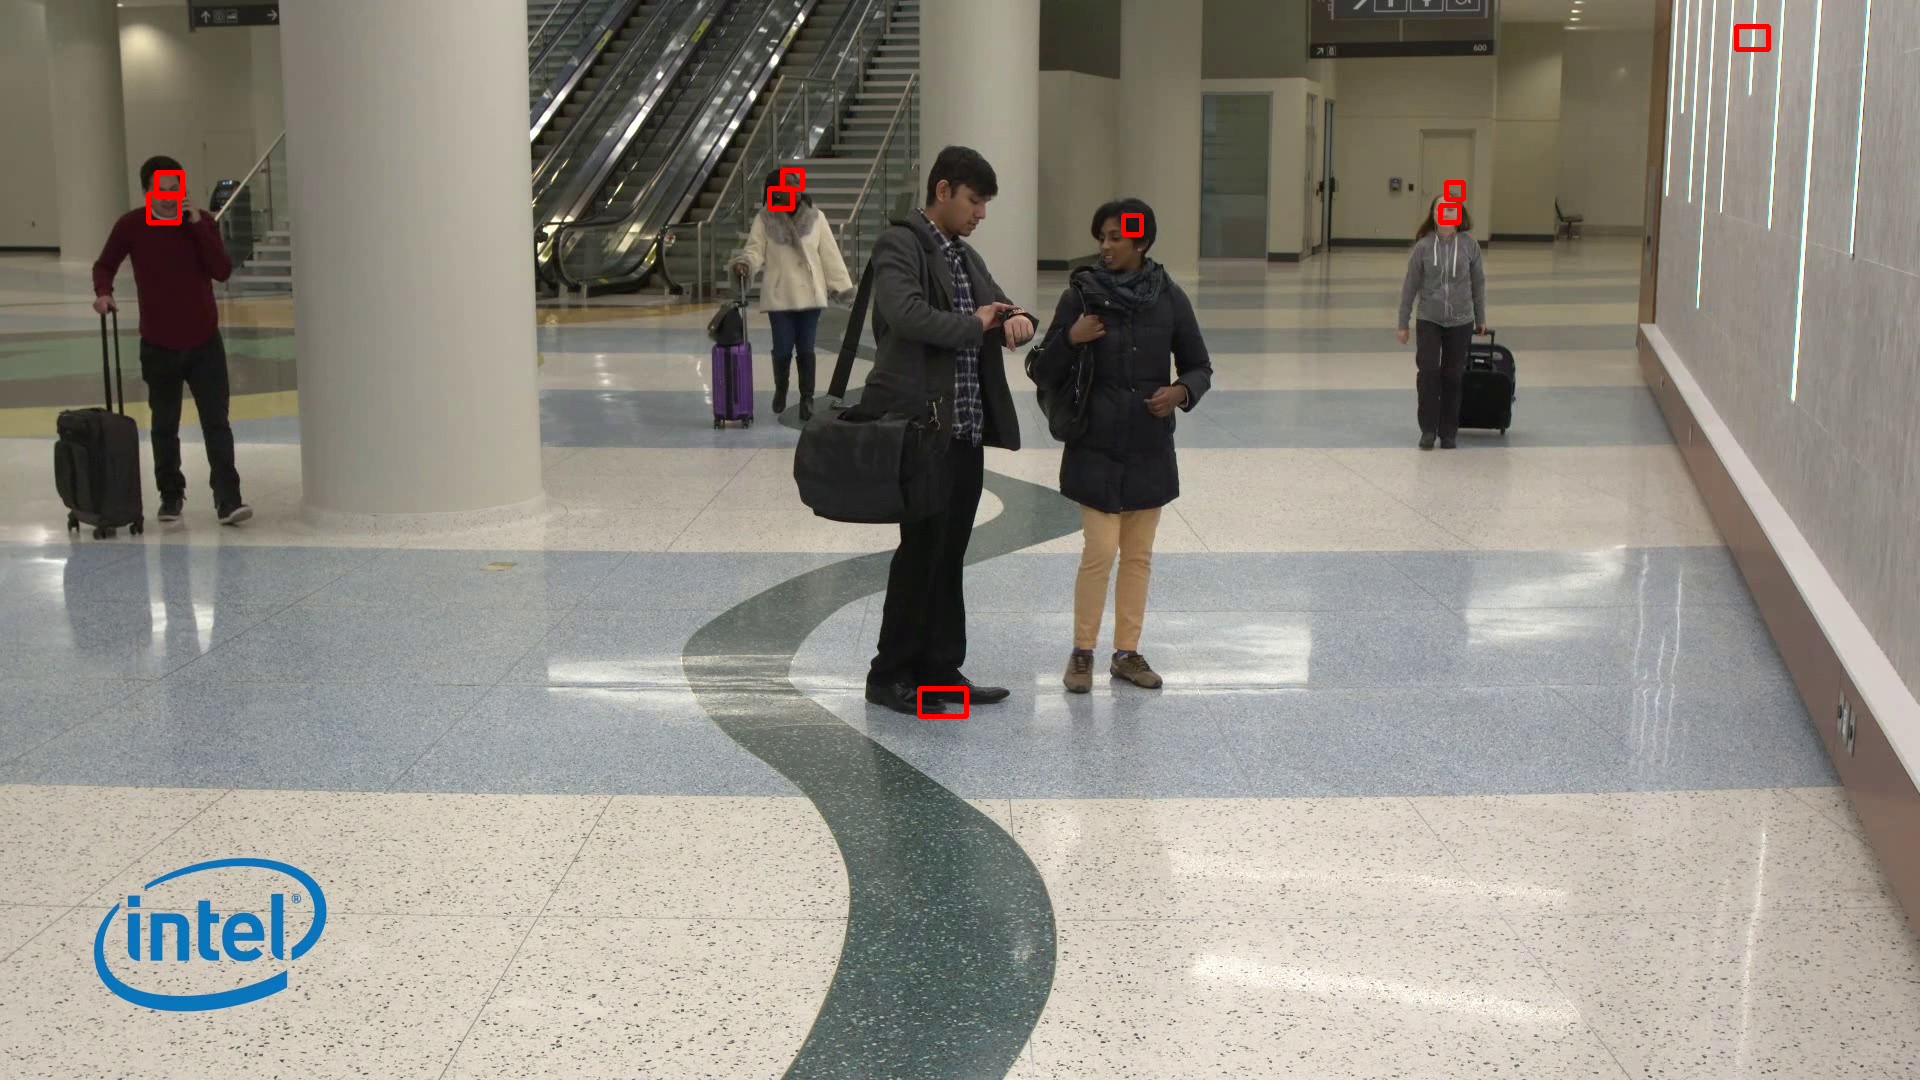

In [13]:
import IPython
import PIL

for predictions, item in zip(predicted_validation_dataset, validation_dataset.with_empty_annotations()):
    image = item.numpy.astype(np.uint8)
    for box in predictions.annotation_scene.shapes:
        x1 = int(box.x1 * image.shape[1])
        x2 = int(box.x2 * image.shape[1])
        y1 = int(box.y1 * image.shape[0])
        y2 = int(box.y2 * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    IPython.display.display(PIL.Image.fromarray(image))